In [3]:
from tensorflow.keras.models import load_model

In [4]:
ankle_ap_view = load_model("Models/Ankle_ap_veiw.hdf5")
ankle_lateral_view = load_model("Models/Ankle_lateral_veiw.hdf5")
ankle_oblique_view = load_model("Models/Ankle_oblique_veiw.hdf5")

foot_ap_view = load_model("Models/Foot_ap_veiw.hdf5")
foot_lateral_view = load_model("Models/Foot_lateral_veiw.hdf5")
foot_oblique_view = load_model("Models/Foot_oblique_veiw.hdf5")

In [6]:
from PIL import Image
import numpy as np

In [84]:
def load_image(img_path, shape, gray=False):
    img = Image.open(img_path)
    img = img.resize(shape)
    if gray:
        img = img.convert('L')
    
    img = np.asarray(img)/255.
    return img

In [85]:
ankle_ap = load_image(r"E:\Dr. Soheil\FIXUS-App\ap-view-ankle.jpg", (140,200))
ankle_lateral = load_image(r"E:\Dr. Soheil\FIXUS-App\lateral-view-ankle.jpg", (140,200))
ankle_oblique = load_image(r"E:\Dr. Soheil\FIXUS-App\oblique-view-ankle.jpg", (140,200))

foot_ap = load_image(r"E:\Dr. Soheil\FIXUS-App\ap-view-foot.jpg", (140,200))
foot_lateral = load_image(r"E:\Dr. Soheil\FIXUS-App\1.jpg", (200,120))
foot_oblique = load_image(r"E:\Dr. Soheil\FIXUS-App\oblique-view-foot.jpg", (140,200))


In [117]:
import tensorflow as tf
from tensorflow import keras
def get_saliency_map(model, image, class_idx):
    with tf.GradientTape() as tape:
        image = tf.convert_to_tensor(image)
        tape.watch(image)
        predictions = model(image)
        
        loss = predictions[:, class_idx]
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    # take maximum across channels
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convert to numpy
    gradient = gradient.numpy()
    
    # normaliz between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())
    
    return smap

In [118]:
from tensorflow.keras import backend as K
import cv2

def CAM_multiclass(model,img_set,which_label=None):
    class_weights = model.layers[-1].get_weights()[0]
    final_conv = model.layers[-3]
    get_output = K.function([model.layers[0].input],[final_conv.output,model.layers[-1].output])

    cam_output = np.zeros(shape = [img_set.shape[0],img_set.shape[1],img_set.shape[2],3])

    for img_index in range(img_set.shape[0]):
        input_img = img_set[img_index:img_index+1,...]
        #input_img_rgb = np.concatenate([input_img, input_img, input_img], axis = 3)
        [conv_output,predictions] = get_output([input_img])
        conv_output = conv_output[0,...]
        pred_label = np.argmax(predictions)

        cam = np.zeros(shape = conv_output.shape[:-1])
        if which_label==None:
            for i, w in enumerate(class_weights[:, pred_label]):
                cam += w * conv_output[...,i]
        if not (which_label==None):
            for i, w in enumerate(class_weights[:,  which_label[img_index] ]):
                cam += w * conv_output[...,i]
        cam /= np.max(cam)

        cam_resize = cv2.resize(cam[:,:], (img_set.shape[2],img_set.shape[1]))
        heatmap = cv2.applyColorMap(np.uint8(255*cam_resize), cv2.COLORMAP_JET)
        heatmap = heatmap[...,(2,1,0)]
        heatmap[np.where(cam_resize < 0.1)] = 0
        cam_output[img_index,:,:,:] = heatmap*0.3 + input_img[0,:,:,:]*255
        #cam_output[img_index,:,:,:] = heatmap*0.5 + input_img_rgb[0,:,:,:]

    return cam_output

In [132]:
views_to_label = {0:"Abnormal", 1:"Normal"}

def make_prediction(model, image):
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    pred = model.predict(image)
    i = np.argmax(pred[0])
    label = views_to_label[i]

    map = get_saliency_map(model, image, i)
    heatmap = CAM_multiclass(model, image)
    return label, map, heatmap

In [138]:
label, map, heatmap = make_prediction(ankle_ap_view, ankle_ap)

1/1 [==============================] - 0s 82ms/step


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'cv::colormap::ColorMap::operator ()'


In [136]:
map.shape

(1, 200, 140)

In [134]:
print(label)
plt.imshow(overlay(map[0]/255, ankle_ap))
plt.show()

plt.imshow(heatmap[0]/255)
plt.show()

Abnormal


ValueError: operands could not be broadcast together with shapes (200,140) (200,140,3) 

In [126]:
label, map, heatmap  = make_prediction(foot_ap_view, foot_ap)

1/1 [==============================] - 0s 67ms/step


In [102]:
cam_rslt_te = CAM_multiclass(foot_oblique_view,foot_oblique.reshape(1,200,140,3))

In [103]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


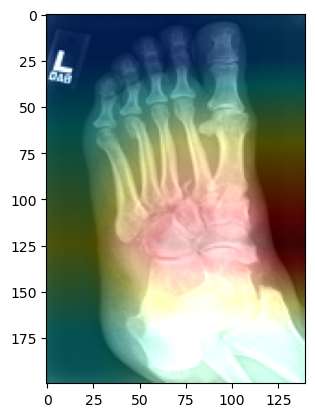

In [104]:
plt.imshow(cam_rslt_te[0]/255.)